<a href="https://colab.research.google.com/github/kvakhil/Machine-Learning-CS-545/blob/main/Neural_Network_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A4-Neural-Network-Classifier" data-toc-modified-id="A4-Neural-Network-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A4 Neural Network Classifier</a></span><ul class="toc-item"><li><span><a href="#NeuralNetworkClassifier" data-toc-modified-id="NeuralNetworkClassifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>NeuralNetworkClassifier</code></a></span></li><li><span><a href="#percent_correct" data-toc-modified-id="percent_correct-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>percent_correct</code></a></span></li><li><span><a href="#Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits" data-toc-modified-id="Apply-NeuralNetworkClassifier-to-Images-of-Handwritten-Digits-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Apply <code>NeuralNetworkClassifier</code> to Images of Handwritten Digits</a></span></li><li><span><a href="#Define-train_for_best_validation-and-apply-to-MNIST-data" data-toc-modified-id="Define-train_for_best_validation-and-apply-to-MNIST-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define <code>train_for_best_validation</code> and apply to MNIST data</a></span></li></ul></li><li><span><a href="#Grading" data-toc-modified-id="Grading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# A4 Neural Network Classifier

## `NeuralNetworkClassifier`

Starting with the `NeuralNetwork` class defined in Lecture Notes 12, complete the subclass `NeuralNetworkClassifier` as discussed.

## `percent_correct`

When trying to classify real data, we need a way to evaluate our performance.  One way is to just calculate the percent of samples correctly classified, and to show a confusion matrix.  Define the function
`percent_correct(Y, T)`, that returns the percent of samples correctly classified, given `T` as a column matrix of class labels, and `Y` as the column matrix of classes predicted by `use`.

In [ ]:
import numpy as np
import optimizers as opt
import sys

In [ ]:
class NeuralNetwork():

    def __init__(self, n_inputs, n_hiddens_list, n_outputs):

        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        self.n_layers = len(n_hiddens_list) + 1

        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        self.all_gradients, self.Gs = self.make_weights()

        self.stand_params = None
        self.error_trace = []

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'

    def make_weights(self):
        # Create list of matrix shapes, one per layer
        n_in = self.n_inputs
        units = self.n_hiddens_list + [self.n_outputs]
        shapes = []
        for n_units in units:
            shapes.append((n_in + 1, n_units))
            n_in = n_units

        # Allocate contiguous memory to hold all weights
        n_weights = sum([ni * nu for (ni, nu) in shapes])
        all_weights = np.zeros(n_weights)

        # Create numpy views into this memory with the appropriate
        # shapes to be our weight matrices.
        Ws = []
        first = 0
        for (ni, nu) in shapes:
            n_w = ni * nu
            W = all_weights[first:first + n_w].reshape(ni, nu)
            Ws.append(W)
            first += n_w

        return all_weights, Ws

    def initialize_weights(self):
        for W in self.Ws:
            ni, nu = W.shape
            W[:] = np.random.uniform(-1, 1, size=(ni, nu)) / np.sqrt(ni)
        self.error_trace = []

    def forward(self,Xst):
        Ys = [Xst]
        for layer_i, W in enumerate(self.Ws):
            X = Ys[-1]
            Y = self.add_ones(X) @ W
            if layer_i < self.n_layers - 1:
                Y = np.tanh(Y)
            Ys.append(Y)
        return Ys[1:]  # remove X from Ys

    def backward(self, Xst, Tst):
        n_samples = Xst.shape[0]

        Ys = self.forward(Xst)
        Ys = [Xst] + Ys  # Ys now has n_layers + 1 elements.  Ws still has n_layers elements.
        delta = - (Tst - Ys[-1]) / (n_samples * self.n_outputs)
        for layeri in range(self.n_layers)[::-1]:
            X = Ys[layeri]
            self.Gs[layeri][:] = self.add_ones(X).T @ delta
            if layeri > 0:
                delta = delta @ self.Ws[layeri][1:, :].T
                Y = X  # Ys[layeri]
                delta *= 1 - Ys[layeri] ** 2
            # if layeri < self.n_layers - 1:
            #     delta *= 1 - Y ** 2
        # print(self.all_gradients)
        return self.all_gradients

    def mse(self, Xst, Tst):
        Yst = self.forward(Xst)
        return 0.5 * np.mean((Tst - Yst[-1])**2)

    def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        Tst = self.standardize_T(T)

        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)
            
        error_trace = optimizer(self.mse, self.backward, [Xst, Tst],
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        self.error_trace += error_trace
        return self

    def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        Y = self.unstandardize_T(Y)
        Zs = Ys[:-1]
        return (Y, Zs) if return_hidden_layer_outputs else Y

    def get_error_trace(self):
        return self.error_trace

    def add_ones(self, X):
        return np.insert(X, 0, 1, axis=1)

    def calc_standardize_parameters(self, X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Xstds[Xstds == 0] = np.mean(Xstds[Xstds > 0])
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds, 'Tmeans': Tmeans, 'Tstds': Tstds}

    def standardize_X(self, X):
        return (X - self.stand_params['Xmeans']) / self.stand_params['Xstds']

    def unstandardize_X(self, Xst):
        return Xst * self.stand_params['Xstds'] + self.stand_params['Xmeans']

    def standardize_T(self, T):
        return (T - self.stand_params['Tmeans']) / self.stand_params['Tstds']

    def unstandardize_T(self, Tst):
        return Tst * self.stand_params['Tstds'] + self.stand_params['Tmeans']

In [ ]:
 def make_indicator_variables(T):
        '''Assumes argument is N x 1, N samples each being integer class label.'''
        # Make sure T is two-dimensional. Should be n_samples x 1.
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)


In [ ]:
class NeuralNetworkClassifier(NeuralNetwork):

  def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = max(0, np.max(Y))
        expY = np.exp(Y - maxY)
        denom = np.sum(expY, axis=1).reshape((-1, 1)) 
        Y = expY / (denom + sys.float_info.epsilon)             # requires an    import sys
        return Y


 
  def forward(self,Xst):
        # Calculate the outputs, Z, of all hidden units, given all input samples in X.
        output_list=[]
        if (len(self.n_hiddens_list)==0):
          Yst = self.add_ones(Xst) @ self.Ws[-1]
          Yst = self.softmax(Yst)
          output_list.append(Yst)
        
        else:
          for W in self.Ws:
            Z = np.tanh(self.add_ones(Xst) @ W)
            output_list.append(Z);
            Xst=Z
          output_list.pop()
          # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
          Yst = self.add_ones(output_list[-1]) @ self.Ws[-1]
          Yst = self.softmax(Yst)
          output_list.append(Yst)

        return output_list

  # def neg_log_likelihood(self, Xst, T):  # T must be indicator variables
  #     sum=0
  #     total_sum=0
  #     for i in range(len(Xst)):
  #       for j in range(len(Xst[0])):
  #           sum+=T[i,j]*math.log(X[i,j])
  #       total_sum+=sum
  #       sum=0

  #     print(total_sum)

  #     return total_sum/np.mean(Xst)

  def neg_log_likelihood(self, Xst, T):
            # w = warg.reshape((-1,K))
            # if(len(self.forward(Xst))>0):
            Y = self.forward(Xst)[-1]
            return - np.mean(T * np.log(Y + sys.float_info.epsilon))
            # return
  

  def use(self, X, return_hidden_layer_outputs=False):
        Xst = self.standardize_X(X)
        Ys = self.forward(Xst)
        Y = Ys[-1]
        classes = np.argmax(Y, axis=1).reshape(-1,1)
        Zs = Ys[:-1]
        return (classes, Y, Zs) if return_hidden_layer_outputs else (classes, Y)


 


  def train(self, X, T, n_epochs, learning_rate=0.01, method='scg', verbose=True):

        self.stand_params = self.calc_standardize_parameters(X, T)
        Xst = self.standardize_X(X)
        # Tst = self.standardize_T(T)                                  ## CHANGED

        # NEW PART FROM HERE ...
        
        self.classes, counts = np.unique(T, return_counts=True)
        self.most_common_class = self.classes[np.argmax(counts)]

        if self.n_outputs != len(self.classes):
            raise ValueError(f'''In NeuralNetworkClassifier, the number of outputs must equal
the number of classes in the training data. The given number of outputs
is {self.n_outputs} and number of classes is {len(self.classes)}. Try changing
the number of outputs in the call to NeuralNetworkClassifier().''')

        T_ind_vars = make_indicator_variables(T)
  
        #   ... TO HERE
        
        if method == 'sgd':
            optimizer = opt.Optimizers(self.all_weights).sgd
        elif method == 'adam':
            optimizer = opt.Optimizers(self.all_weights).adam
        elif method == 'scg':
            optimizer = opt.Optimizers(self.all_weights).scg
        else:
            print('train: method must be \'sgd\', \'adam\', or \'scg\'.')

        def error_convert(negLL):
            return np.exp(-negLL)                                                    ## CHANGED
            
        error_trace = optimizer(self.neg_log_likelihood, self.backward, [Xst, T_ind_vars],   ## CHANGED
                                n_epochs, learning_rate,
                                error_convert_f=error_convert,
                                verbose=verbose)
        
        self.error_trace += error_trace
        return self
    


In [ ]:

def percent_correct(p, T):
    n=0
    for i in range(len(p)):
      if(p[i]==T[i]):
        n+=1
    return n*100/float(len(T))

In [ ]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
T = np.array([[0], [1], [1], [0]])
X, T

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]), array([[0],
        [1],
        [1],
        [0]]))

In [ ]:

np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [ ]:
nnet.Ws

[array([[ 0.12952296, -0.38212533, -0.07383268,  0.31091752, -0.23633798,
         -0.40511172, -0.55139454, -0.09211682, -0.30174387, -0.18745848],
        [ 0.56662595, -0.3028474 , -0.48359706,  0.19583749,  0.13999926,
         -0.26066957, -0.03900416, -0.44067096, -0.49195143,  0.46277416],
        [ 0.33943873,  0.39325596,  0.36397022,  0.56690583,  0.08922813,
          0.36230683, -0.09085429, -0.5456561 , -0.05295844, -0.45573018]]),
 array([[ 0.19129089,  0.11923431],
        [ 0.03936858, -0.13614606],
        [ 0.30059098, -0.21826885],
        [ 0.06959828, -0.00902345],
        [-0.05727085,  0.13739817],
        [-0.10684722, -0.05997329],
        [-0.10916737,  0.26968491],
        [ 0.25249064,  0.18925528],
        [-0.28096209,  0.2673639 ],
        [ 0.27162504,  0.18488136],
        [-0.01128977,  0.2814664 ]])]

If you add some print statements in `neg_log_likelihood` functions, you can compare your output to the following results.

In [ ]:
nnet.train(X, T, 1, 0.1, method='sgd')

sgd: Epoch 1 Error=0.69995


NeuralNetwork(2, [10], 2)

In [ ]:
np.exp(-0.35674)

0.6999544622383824

Now if you comment out those print statements, you can run for more epochs without tons of output.

In [ ]:
np.random.seed(111)
nnet = NeuralNetworkClassifier(2, [10], 2)

In [ ]:
nnet.train(X, T, 100, method='scg')

SCG: Epoch 10 Error=0.99066
SCG: Epoch 20 Error=0.99994
SCG: Epoch 30 Error=1.00000


NeuralNetwork(2, [10], 2)

In [ ]:
nnet.use(X)

(array([[0],
        [1],
        [1],
        [0]]), array([[9.99999987e-01, 1.28218250e-08],
        [1.00942365e-08, 9.99999990e-01],
        [8.79700915e-09, 9.99999991e-01],
        [9.99999979e-01, 2.13196375e-08]]))

In [ ]:
percent_correct(nnet.use(X)[0], T)

100.0

Works!  The XOR problem was used early in the history of neural networks as a problem that cannot be solved with a linear model.  Let's try it.  It turns out our neural network code can do this if we use an empty list for the hidden unit structure!

In [ ]:

nnet = NeuralNetworkClassifier(2, [], 2)
nnet.train(X, T, 100)   # default method is 'scg'

NeuralNetwork(2, [], 2)

In [ ]:
nnet.use(X)

(array([[1],
        [1],
        [1],
        [1]]), array([[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]))

In [ ]:
percent_correct(nnet.use(X)[0], T)

50.0

A second way to evaluate a classifier is to calculate a confusion matrix. This shows the percent accuracy for each class, and also shows which classes are predicted in error.

Here is a function you can use to show a confusion matrix.

In [ ]:
import pandas

def confusion_matrix(Y_classes, T):
    class_names = np.unique(T)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    # cf.style.background_gradient(cmap='Blues').format("{:.1f} %")
    print('Percent Correct')
    return conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}")

In [ ]:
confusion_matrix(nnet.use(X)[0], T)

Percent Correct


,0,1
0,0.0,100.0
1,0.0,100.0


## Apply `NeuralNetworkClassifier` to Images of Handwritten Digits

Apply your `NeuralNetworkClassifier` to the [MNIST digits dataset](http://deeplearning.net/tutorial/gettingstarted.html).

In [ ]:
import pickle
import gzip
import matplotlib.pyplot as plt


In [ ]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [ ]:
28*28

784

In [ ]:
def draw_image(image, label):
    plt.imshow(-image.reshape(28, 28), cmap='gray')
    # plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(label)

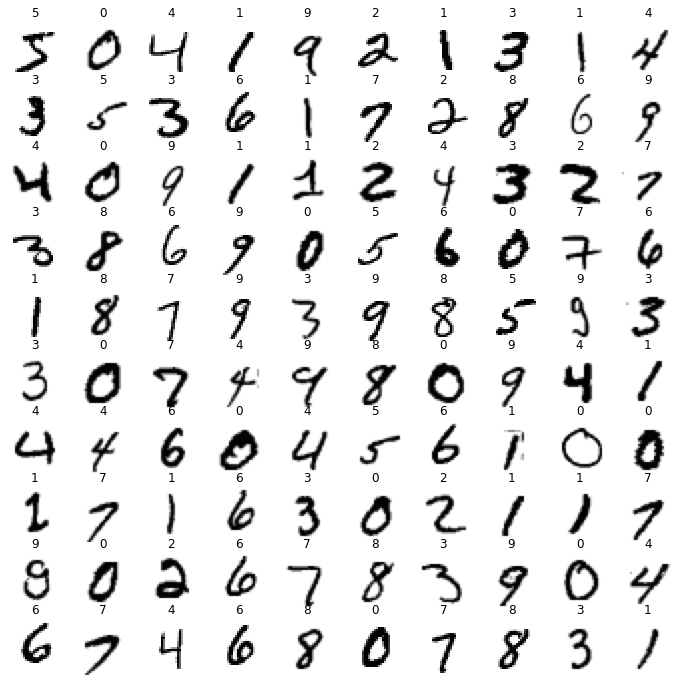

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    draw_image(Xtrain[i], Ttrain[i,0])

In [ ]:
nnet = NeuralNetworkClassifier(784, [], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.95274
SCG: Epoch 8 Error=0.96850
SCG: Epoch 12 Error=0.97250
SCG: Epoch 16 Error=0.97345
SCG: Epoch 20 Error=0.97345
SCG: Epoch 24 Error=0.97345
SCG: Epoch 28 Error=0.97345
SCG: Epoch 32 Error=0.97427
SCG: Epoch 36 Error=0.97538
SCG: Epoch 40 Error=0.97590


NeuralNetwork(784, [], 10)

In [ ]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[93.296, 92.77, 92.28]

In [ ]:
nnet = NeuralNetworkClassifier(784, [20], 10)
nnet.train(Xtrain, Ttrain, 40)

SCG: Epoch 4 Error=0.93443
SCG: Epoch 8 Error=0.96726
SCG: Epoch 12 Error=0.97608
SCG: Epoch 16 Error=0.98063
SCG: Epoch 20 Error=0.98351
SCG: Epoch 24 Error=0.98551
SCG: Epoch 28 Error=0.98707
SCG: Epoch 32 Error=0.98835
SCG: Epoch 36 Error=0.98938
SCG: Epoch 40 Error=0.99024


NeuralNetwork(784, [20], 10)

In [ ]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest],
                                                    [Ttrain, Tval, Ttest])]

[97.45, 93.65, 93.48]

## Define `train_for_best_validation` and apply to MNIST data

Using the function `run` from Lecture Notes 11 as a guide, define a new function `train_for_best_validation` that accepts arguments
* `Xtrain, Ttrain`: matrices of shapes $N\times D$ and $N\times 1$ as input and target training data, where $N$ is number of training samples and $D$ is number of input components,
* `Xval, Tval`: matrices of shapes  $N\times D$ and $N\times 1$ of validation data ($N$ not same value as above)
* `n_epochs`: total number of epochs to train for,
* `n_epochs_per_train`: divide `n_epochs` by this value to get number of times the neural network `train` function is called for this many epochs,
* `n_hiddens_list`: structure of hidden layers,
* `method`: optimizer method,
* `learning_rate`: used for optimizer methods 'adam' and 'sgd'.

It must return 
* `nnet`: resulting neural network with weights that produced the highest accuracy for the validation data set,
* `epoch`: epoch corresponding to best validation accuracy,
* `train_accuracy`: accuracy at that best epoch on training data,
* `val_accuracy`: accuracy at that best epoch on validation data.

This function should call your `percent_correct` function to calculate classification accuracies.

Apply it to the MNIST data as shown below.

In [ ]:
def train_for_best_validation(Xtrain, Ttrain, Xtest, Ttest, n_epochs, n_epochs_per_train, n_hiddens_list, method, learning_rate=None):
    
    n_reps = n_epochs // n_epochs_per_train
    n_epochs_last_train = n_epochs - n_reps * n_epochs_per_train
    if n_epochs_last_train > 0:
        n_reps += 1

    Ttr = make_indicator_variables(Ttrain)
    tts = make_indicator_variables(Ttest)

    nnet = NeuralNetworkClassifier(Xtrain.shape[1], n_hiddens_list, Ttr.shape[1])
    best_all_weights = nnet.all_weights.copy()
    best_so_far = np.inf

    rmses = []
    for reps in range(n_reps):
        n_epoch = n_epochs_per_train 
        if n_epochs_last_train > 0 and reps == n_reps-1:
            n_epoch = n_epochs_last_train
            
        nnet.train(Xtrain, Ttrain, n_epoch, method='scg', verbose=False)

     
        
        train_rmse = percent_correct(nnet.use(Xtrain)[0], Ttrain)
        test_rmse = percent_correct(nnet.use(Xtest)[0], Ttest)
        
        rmses.append([(reps + 1) * n_epoch, train_rmse, test_rmse])

        print("epoch: ", (reps + 1) * n_epoch,"  Train Accuracy: ", train_rmse,"  Validation Accuracy: ",test_rmse )
        
        if test_rmse < best_so_far:
            best_so_far = test_rmse
            best_all_weights[:] = nnet.all_weights
        
        
    rmses = np.array(rmses)
    best_test_index = np.argmax(rmses[:, -1])
    best_test_epoch, best_test_train_rmse, best_test_test_rmse = rmses[best_test_index, :]
    print(f'Best test error is at epoch {best_test_epoch}', end='')
    print(f' with  Train Accuracy of {best_test_train_rmse:.2f} and Validation Accuracy of {best_test_test_rmse:.2f}')
        
    plt.plot(rmses[:, 0], rmses[:, 1], label='Train')
    plt.plot(rmses[:, 0], rmses[:, 2], label='Validation')
    plt.legend()
    ymin, ymax = plt.ylim()
    plt.plot([best_test_epoch, best_test_epoch], [ymin, ymax], 'r')
    plt.xlabel(f'Epochs')
    plt.ylabel('RMSE')
    
    # Put best weights into nnet
    nnet.all_weights[:] = best_all_weights
    
    return nnet, best_test_epoch, best_test_train_rmse, best_test_test_rmse

epoch:  10   Train Accuracy:  92.138   Validation Accuracy:  92.57
epoch:  20   Train Accuracy:  94.782   Validation Accuracy:  94.03
epoch:  30   Train Accuracy:  96.144   Validation Accuracy:  94.26
epoch:  40   Train Accuracy:  96.852   Validation Accuracy:  94.28
epoch:  50   Train Accuracy:  97.328   Validation Accuracy:  94.41
epoch:  60   Train Accuracy:  97.626   Validation Accuracy:  94.45
epoch:  70   Train Accuracy:  97.882   Validation Accuracy:  94.43
epoch:  80   Train Accuracy:  98.034   Validation Accuracy:  94.17
epoch:  90   Train Accuracy:  98.258   Validation Accuracy:  94.29
epoch:  100   Train Accuracy:  98.438   Validation Accuracy:  94.18
epoch:  110   Train Accuracy:  98.616   Validation Accuracy:  94.13
epoch:  120   Train Accuracy:  98.744   Validation Accuracy:  94.09
epoch:  130   Train Accuracy:  98.864   Validation Accuracy:  93.94
epoch:  140   Train Accuracy:  98.996   Validation Accuracy:  93.95
epoch:  150   Train Accuracy:  99.092   Validation Accura

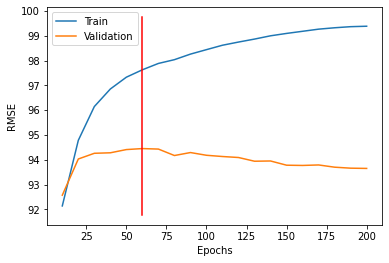

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='scg') 

In [ ]:
[percent_correct(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

[92.138, 92.57, 91.66]

In [ ]:
confusion_matrix(nnet.use(Xtest)[0], Ttest)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,96.7,0.0,0.0,0.2,0.5,0.6,1.6,0.1,0.2,0.0
1,0.0,96.6,0.4,0.4,0.1,0.1,0.4,0.2,1.9,0.0
2,1.6,0.4,89.0,2.2,1.2,0.1,1.6,0.9,2.9,0.2
3,0.5,0.4,2.0,90.4,0.2,2.8,0.2,1.9,1.3,0.4
4,0.2,0.3,0.7,0.0,93.2,0.0,1.0,0.3,0.6,3.7
5,1.0,0.3,0.4,4.0,1.7,87.0,1.6,0.7,2.7,0.6
6,1.9,0.4,0.3,0.0,0.9,2.3,93.6,0.1,0.4,0.0
7,0.2,0.7,1.8,0.9,0.5,0.0,0.0,91.8,0.2,4.0
8,0.9,0.4,1.1,2.6,1.1,3.5,1.1,1.1,87.6,0.5
9,1.1,0.4,0.1,1.5,3.5,0.9,0.4,1.5,0.9,89.8


In [ ]:
[confusion_matrix(nnet.use(X)[0], T) for X, T in zip([Xtrain, Xval, Xtest], [Ttrain, Tval, Ttest])]

Percent Correct
Percent Correct
Percent Correct


epoch:  10   Train Accuracy:  92.79   Validation Accuracy:  93.19
epoch:  20   Train Accuracy:  95.458   Validation Accuracy:  94.24
epoch:  30   Train Accuracy:  96.478   Validation Accuracy:  94.42
epoch:  40   Train Accuracy:  97.114   Validation Accuracy:  94.41
epoch:  50   Train Accuracy:  97.584   Validation Accuracy:  94.3
epoch:  60   Train Accuracy:  97.904   Validation Accuracy:  94.3
epoch:  70   Train Accuracy:  98.174   Validation Accuracy:  94.13
epoch:  80   Train Accuracy:  98.378   Validation Accuracy:  94.19
epoch:  90   Train Accuracy:  98.594   Validation Accuracy:  94.04
epoch:  100   Train Accuracy:  98.744   Validation Accuracy:  93.98
epoch:  110   Train Accuracy:  98.868   Validation Accuracy:  93.98
epoch:  120   Train Accuracy:  98.97   Validation Accuracy:  93.89
epoch:  130   Train Accuracy:  99.064   Validation Accuracy:  93.86
epoch:  140   Train Accuracy:  99.158   Validation Accuracy:  93.87
epoch:  150   Train Accuracy:  99.234   Validation Accuracy: 

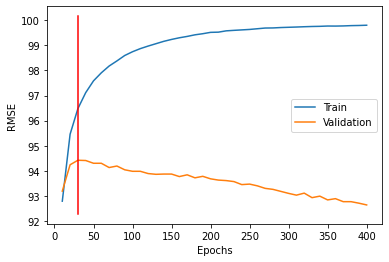

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      400, 10, [20], method='scg') 

epoch:  10   Train Accuracy:  76.064   Validation Accuracy:  78.31
epoch:  20   Train Accuracy:  89.444   Validation Accuracy:  89.96
epoch:  30   Train Accuracy:  92.952   Validation Accuracy:  92.49
epoch:  40   Train Accuracy:  94.694   Validation Accuracy:  93.28
epoch:  50   Train Accuracy:  95.624   Validation Accuracy:  93.6
epoch:  60   Train Accuracy:  96.376   Validation Accuracy:  93.84
epoch:  70   Train Accuracy:  96.884   Validation Accuracy:  93.69
epoch:  80   Train Accuracy:  97.268   Validation Accuracy:  93.83
epoch:  90   Train Accuracy:  97.56   Validation Accuracy:  93.71
epoch:  100   Train Accuracy:  97.77   Validation Accuracy:  93.72
epoch:  110   Train Accuracy:  97.946   Validation Accuracy:  93.77
epoch:  120   Train Accuracy:  98.066   Validation Accuracy:  93.75
epoch:  130   Train Accuracy:  98.322   Validation Accuracy:  93.66
epoch:  140   Train Accuracy:  98.572   Validation Accuracy:  93.8
epoch:  150   Train Accuracy:  98.688   Validation Accuracy: 

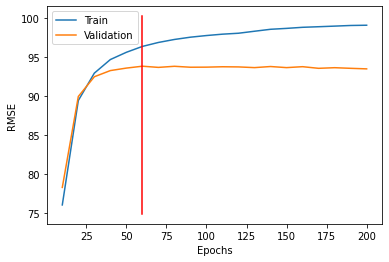

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20,10,30], method='scg') 

epoch:  5   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  10   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  15   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  20   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  25   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  30   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  35   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  40   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  45   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  50   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  55   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  60   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  65   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  70   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  75   Train Accuracy:  9.69   Validation Accuracy:  9.42
epoch:  80   Train Accuracy:  9.69   Vali

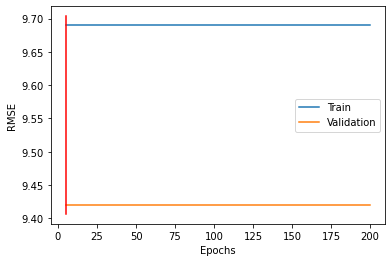

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 5, [20,10,30], method='scg') 

epoch:  10   Train Accuracy:  73.124   Validation Accuracy:  75.38
epoch:  20   Train Accuracy:  91.4   Validation Accuracy:  91.92
epoch:  30   Train Accuracy:  95.488   Validation Accuracy:  94.65
epoch:  40   Train Accuracy:  97.578   Validation Accuracy:  95.63
epoch:  50   Train Accuracy:  98.69   Validation Accuracy:  95.89
epoch:  60   Train Accuracy:  99.394   Validation Accuracy:  96.18
epoch:  70   Train Accuracy:  99.762   Validation Accuracy:  96.27
epoch:  80   Train Accuracy:  99.938   Validation Accuracy:  96.24
epoch:  90   Train Accuracy:  99.99   Validation Accuracy:  96.17
epoch:  100   Train Accuracy:  100.0   Validation Accuracy:  96.15
epoch:  110   Train Accuracy:  100.0   Validation Accuracy:  96.08
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  96.26
epoch:  130   Train Accuracy:  100.0   Validation Accuracy:  96.26
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  96.23
epoch:  150   Train Accuracy:  100.0   Validation Accuracy:  96.29

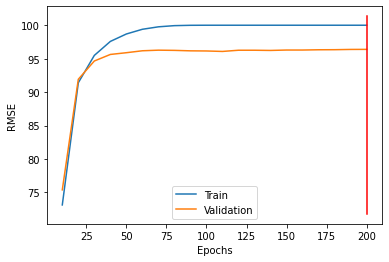

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [100,50,100], method='scg') 

epoch:  10   Train Accuracy:  73.222   Validation Accuracy:  74.62
epoch:  20   Train Accuracy:  92.138   Validation Accuracy:  92.18
epoch:  30   Train Accuracy:  96.348   Validation Accuracy:  95.33
epoch:  40   Train Accuracy:  98.192   Validation Accuracy:  96.06
epoch:  50   Train Accuracy:  99.2   Validation Accuracy:  96.27
epoch:  60   Train Accuracy:  99.672   Validation Accuracy:  96.27
epoch:  70   Train Accuracy:  99.878   Validation Accuracy:  96.27
epoch:  80   Train Accuracy:  99.956   Validation Accuracy:  96.18
epoch:  90   Train Accuracy:  99.98   Validation Accuracy:  96.24
epoch:  100   Train Accuracy:  99.996   Validation Accuracy:  96.28
epoch:  110   Train Accuracy:  99.998   Validation Accuracy:  96.34
epoch:  120   Train Accuracy:  99.998   Validation Accuracy:  96.31
epoch:  130   Train Accuracy:  100.0   Validation Accuracy:  96.22
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  96.28
epoch:  150   Train Accuracy:  100.0   Validation Accuracy:  9

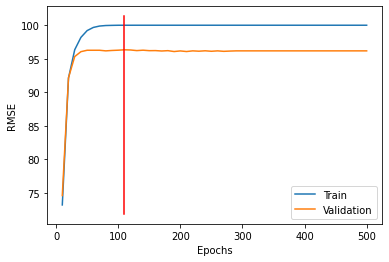

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      500, 10, [100,50,20], method='scg') 

epoch:  20   Train Accuracy:  94.036   Validation Accuracy:  93.6
epoch:  40   Train Accuracy:  98.18   Validation Accuracy:  95.91
epoch:  60   Train Accuracy:  99.712   Validation Accuracy:  96.03
epoch:  80   Train Accuracy:  99.968   Validation Accuracy:  95.92
epoch:  100   Train Accuracy:  99.998   Validation Accuracy:  96.1
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  96.03
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  95.97
epoch:  160   Train Accuracy:  100.0   Validation Accuracy:  95.84
epoch:  180   Train Accuracy:  100.0   Validation Accuracy:  95.86
epoch:  200   Train Accuracy:  100.0   Validation Accuracy:  95.78
epoch:  220   Train Accuracy:  100.0   Validation Accuracy:  95.78
epoch:  240   Train Accuracy:  100.0   Validation Accuracy:  95.78
epoch:  260   Train Accuracy:  100.0   Validation Accuracy:  95.78
epoch:  280   Train Accuracy:  100.0   Validation Accuracy:  95.78
epoch:  300   Train Accuracy:  100.0   Validation Accuracy:  95.

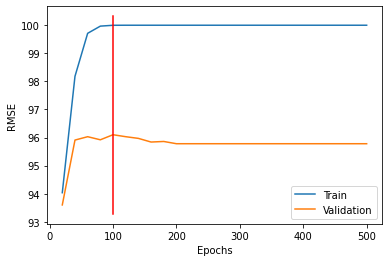

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      500, 20, [100,50,20], method='scg') 

epoch:  10   Train Accuracy:  11.356   Validation Accuracy:  10.64
epoch:  20   Train Accuracy:  21.282   Validation Accuracy:  21.25
epoch:  30   Train Accuracy:  22.584   Validation Accuracy:  22.62
epoch:  40   Train Accuracy:  24.116   Validation Accuracy:  24.06
epoch:  50   Train Accuracy:  21.958   Validation Accuracy:  21.65
epoch:  60   Train Accuracy:  26.492   Validation Accuracy:  27.18
epoch:  70   Train Accuracy:  28.08   Validation Accuracy:  28.79
epoch:  80   Train Accuracy:  28.31   Validation Accuracy:  28.88
epoch:  90   Train Accuracy:  28.902   Validation Accuracy:  29.26
epoch:  100   Train Accuracy:  30.614   Validation Accuracy:  30.88
Best test error is at epoch 100.0 with  Train Accuracy of 30.61 and Validation Accuracy of 30.88


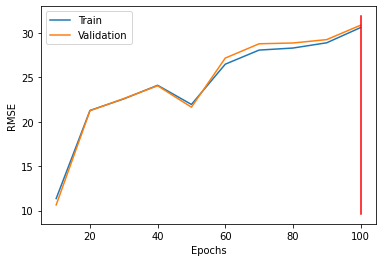

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [50]*20, method='scg') 

epoch:  10   Train Accuracy:  11.356   Validation Accuracy:  10.64
epoch:  20   Train Accuracy:  18.86   Validation Accuracy:  19.34
epoch:  30   Train Accuracy:  19.244   Validation Accuracy:  19.67
epoch:  40   Train Accuracy:  32.364   Validation Accuracy:  32.84
epoch:  50   Train Accuracy:  33.836   Validation Accuracy:  33.98
epoch:  60   Train Accuracy:  37.764   Validation Accuracy:  37.1
epoch:  70   Train Accuracy:  42.13   Validation Accuracy:  41.49
epoch:  80   Train Accuracy:  43.446   Validation Accuracy:  44.13
epoch:  90   Train Accuracy:  45.936   Validation Accuracy:  45.91
epoch:  100   Train Accuracy:  48.66   Validation Accuracy:  48.31
Best test error is at epoch 100.0 with  Train Accuracy of 48.66 and Validation Accuracy of 48.31


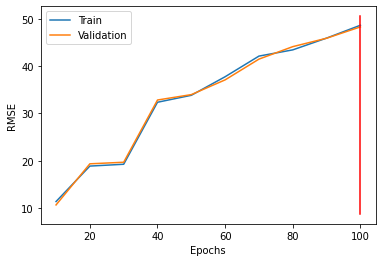

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [50]*20, method='scg') 

epoch:  10   Train Accuracy:  92.012   Validation Accuracy:  92.14
epoch:  20   Train Accuracy:  93.082   Validation Accuracy:  92.78
epoch:  30   Train Accuracy:  93.268   Validation Accuracy:  92.86
epoch:  40   Train Accuracy:  93.392   Validation Accuracy:  92.86
epoch:  50   Train Accuracy:  93.404   Validation Accuracy:  92.89
epoch:  60   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  70   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  80   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  90   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  100   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  110   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  120   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  130   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  140   Train Accuracy:  93.426   Validation Accuracy:  92.88
epoch:  150   Train Accuracy:  93.426   Validation Accura

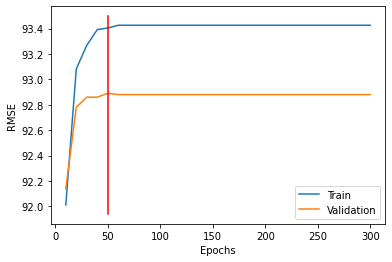

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      300, 10, [], method='scg') 

# SCG OBSERVATIONS


*   The best validation accuracy that I got for SCG was 96.69.
Increasing the number of epochs has no effect on SCG unless the number of neurons and number of layers are increased. Also increasing the number of epochs per train has little to no effect.

* Increasing the number of neurons and layers had a significant increase in the accuracy. I tried to run the model with 20 layers and 50 neurons each and a very low accuracy of about 48%. I suspect this is because I ran it for only 100 epochs, but I think running it for more epochs and maybe more neurons would give me a very good accuracy.
The configuration of model with best accuracy in SCG was epochs= 200, epochs_per _train = 10, hiddens_list =[100,50,100]

* The best validation accuracy occurred at the last epoch, I think increasing the number of epochs could have a increased the accuracy very little because the log likely hood seems to be increasing ever so slightly.

* Most of the time the best validation accuracy occurs around 50 epochs, but when the number of neurons and number of layers are increased the best accuracy occurs at the very last epoch, meaning that more training is required.

* The linear model performed surprisingly well with a 92% validation accuracy.




# SGD

epoch:  10   Train Accuracy:  92.304   Validation Accuracy:  92.39
epoch:  20   Train Accuracy:  94.988   Validation Accuracy:  94.04
epoch:  30   Train Accuracy:  96.292   Validation Accuracy:  94.46
epoch:  40   Train Accuracy:  96.998   Validation Accuracy:  94.54
epoch:  50   Train Accuracy:  97.588   Validation Accuracy:  94.61
epoch:  60   Train Accuracy:  97.858   Validation Accuracy:  94.36
epoch:  70   Train Accuracy:  98.154   Validation Accuracy:  94.47
epoch:  80   Train Accuracy:  98.41   Validation Accuracy:  94.23
epoch:  90   Train Accuracy:  98.518   Validation Accuracy:  94.25
epoch:  100   Train Accuracy:  98.688   Validation Accuracy:  93.96
epoch:  110   Train Accuracy:  98.844   Validation Accuracy:  93.99
epoch:  120   Train Accuracy:  98.95   Validation Accuracy:  93.84
epoch:  130   Train Accuracy:  99.054   Validation Accuracy:  93.99
epoch:  140   Train Accuracy:  99.126   Validation Accuracy:  93.94
epoch:  150   Train Accuracy:  99.38   Validation Accuracy:

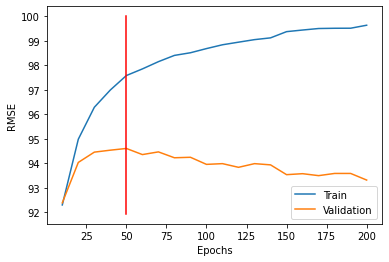

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='sgd', learning_rate= 0.1) 

epoch:  20   Train Accuracy:  95.64   Validation Accuracy:  94.46
epoch:  40   Train Accuracy:  97.568   Validation Accuracy:  94.23
epoch:  60   Train Accuracy:  98.408   Validation Accuracy:  94.05
epoch:  80   Train Accuracy:  98.934   Validation Accuracy:  93.93
epoch:  100   Train Accuracy:  99.174   Validation Accuracy:  93.79
epoch:  120   Train Accuracy:  99.452   Validation Accuracy:  93.4
epoch:  140   Train Accuracy:  99.516   Validation Accuracy:  93.39
epoch:  160   Train Accuracy:  99.638   Validation Accuracy:  93.12
epoch:  180   Train Accuracy:  99.676   Validation Accuracy:  93.21
epoch:  200   Train Accuracy:  99.72   Validation Accuracy:  92.87
epoch:  220   Train Accuracy:  99.75   Validation Accuracy:  92.94
epoch:  240   Train Accuracy:  99.772   Validation Accuracy:  92.76
epoch:  260   Train Accuracy:  99.784   Validation Accuracy:  92.82
epoch:  280   Train Accuracy:  99.798   Validation Accuracy:  92.76
epoch:  300   Train Accuracy:  99.802   Validation Accur

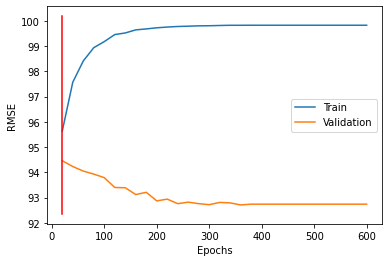

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      600, 20, [20], method='sgd', learning_rate= 0.01) 

epoch:  5   Train Accuracy:  88.11   Validation Accuracy:  88.9
epoch:  10   Train Accuracy:  92.264   Validation Accuracy:  92.57
epoch:  15   Train Accuracy:  94.028   Validation Accuracy:  93.69
epoch:  20   Train Accuracy:  94.824   Validation Accuracy:  93.95
epoch:  25   Train Accuracy:  95.37   Validation Accuracy:  94.25
epoch:  30   Train Accuracy:  95.882   Validation Accuracy:  94.42
epoch:  35   Train Accuracy:  96.134   Validation Accuracy:  94.42
epoch:  40   Train Accuracy:  96.42   Validation Accuracy:  94.52
epoch:  45   Train Accuracy:  96.604   Validation Accuracy:  94.54
epoch:  50   Train Accuracy:  96.81   Validation Accuracy:  94.49
epoch:  55   Train Accuracy:  96.952   Validation Accuracy:  94.5
epoch:  60   Train Accuracy:  97.14   Validation Accuracy:  94.46
epoch:  65   Train Accuracy:  97.322   Validation Accuracy:  94.51
epoch:  70   Train Accuracy:  97.446   Validation Accuracy:  94.37
epoch:  75   Train Accuracy:  97.636   Validation Accuracy:  94.46
epo

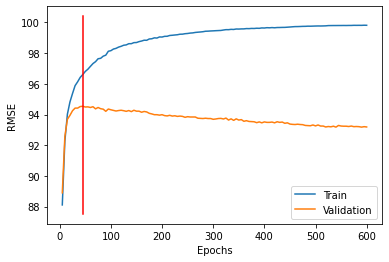

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      600, 5, [20], method='sgd', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  92.964   Validation Accuracy:  93.2
epoch:  20   Train Accuracy:  95.406   Validation Accuracy:  94.09
epoch:  30   Train Accuracy:  96.51   Validation Accuracy:  94.24
epoch:  40   Train Accuracy:  97.18   Validation Accuracy:  94.29
epoch:  50   Train Accuracy:  97.596   Validation Accuracy:  94.17
epoch:  60   Train Accuracy:  97.964   Validation Accuracy:  94.35
epoch:  70   Train Accuracy:  98.186   Validation Accuracy:  94.26
epoch:  80   Train Accuracy:  98.382   Validation Accuracy:  94.17
epoch:  90   Train Accuracy:  98.538   Validation Accuracy:  94.15
epoch:  100   Train Accuracy:  98.652   Validation Accuracy:  94.12
epoch:  110   Train Accuracy:  98.77   Validation Accuracy:  94.12
epoch:  120   Train Accuracy:  98.864   Validation Accuracy:  93.92
epoch:  130   Train Accuracy:  98.98   Validation Accuracy:  93.87
epoch:  140   Train Accuracy:  99.018   Validation Accuracy:  93.74
epoch:  150   Train Accuracy:  99.108   Validation Accuracy:  

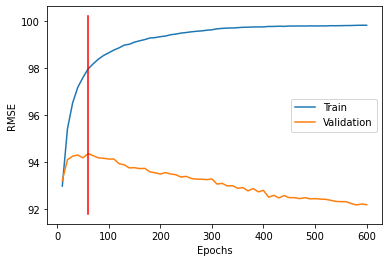

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      600, 10, [20], method='sgd', learning_rate= 0.001) 

epoch:  10   Train Accuracy:  46.566   Validation Accuracy:  46.6
epoch:  20   Train Accuracy:  78.592   Validation Accuracy:  79.93
epoch:  30   Train Accuracy:  87.806   Validation Accuracy:  88.5
epoch:  40   Train Accuracy:  91.64   Validation Accuracy:  90.91
epoch:  50   Train Accuracy:  93.804   Validation Accuracy:  92.6
epoch:  60   Train Accuracy:  95.074   Validation Accuracy:  92.99
epoch:  70   Train Accuracy:  95.784   Validation Accuracy:  93.34
epoch:  80   Train Accuracy:  96.268   Validation Accuracy:  93.39
epoch:  90   Train Accuracy:  96.592   Validation Accuracy:  93.4
epoch:  100   Train Accuracy:  96.862   Validation Accuracy:  93.31
epoch:  110   Train Accuracy:  97.14   Validation Accuracy:  93.37
epoch:  120   Train Accuracy:  97.384   Validation Accuracy:  93.36
epoch:  130   Train Accuracy:  97.612   Validation Accuracy:  93.36
epoch:  140   Train Accuracy:  97.814   Validation Accuracy:  93.19
epoch:  150   Train Accuracy:  98.008   Validation Accuracy:  9

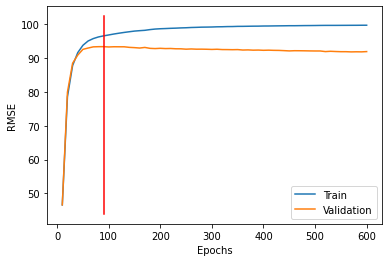

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      600, 10, [30,10,20], method='sgd', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  92.87   Validation Accuracy:  93.16
epoch:  20   Train Accuracy:  96.618   Validation Accuracy:  95.61
epoch:  30   Train Accuracy:  98.548   Validation Accuracy:  96.51
epoch:  40   Train Accuracy:  99.59   Validation Accuracy:  96.74
epoch:  50   Train Accuracy:  99.9   Validation Accuracy:  96.92
epoch:  60   Train Accuracy:  99.994   Validation Accuracy:  96.96
epoch:  70   Train Accuracy:  100.0   Validation Accuracy:  97.13
epoch:  80   Train Accuracy:  100.0   Validation Accuracy:  97.13
epoch:  90   Train Accuracy:  100.0   Validation Accuracy:  97.27
epoch:  100   Train Accuracy:  100.0   Validation Accuracy:  97.2
epoch:  110   Train Accuracy:  100.0   Validation Accuracy:  97.27
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  97.2
epoch:  130   Train Accuracy:  100.0   Validation Accuracy:  97.25
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  97.19
epoch:  150   Train Accuracy:  100.0   Validation Accuracy:  97.22
epoc

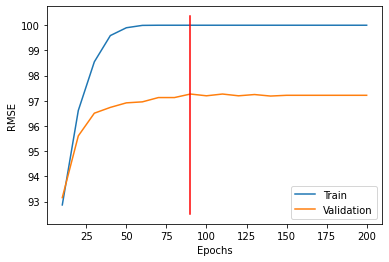

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [200], method='sgd', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  85.256   Validation Accuracy:  86.12
epoch:  20   Train Accuracy:  93.024   Validation Accuracy:  93.21
epoch:  30   Train Accuracy:  96.098   Validation Accuracy:  95.27
epoch:  40   Train Accuracy:  97.446   Validation Accuracy:  95.46
epoch:  50   Train Accuracy:  98.502   Validation Accuracy:  95.8
epoch:  60   Train Accuracy:  99.064   Validation Accuracy:  95.65
epoch:  70   Train Accuracy:  99.514   Validation Accuracy:  95.78
epoch:  80   Train Accuracy:  99.714   Validation Accuracy:  95.62
epoch:  90   Train Accuracy:  99.864   Validation Accuracy:  95.64
epoch:  100   Train Accuracy:  99.924   Validation Accuracy:  95.56
epoch:  110   Train Accuracy:  99.964   Validation Accuracy:  95.51
epoch:  120   Train Accuracy:  99.98   Validation Accuracy:  95.47
epoch:  130   Train Accuracy:  99.99   Validation Accuracy:  95.45
epoch:  140   Train Accuracy:  99.992   Validation Accuracy:  95.47
epoch:  150   Train Accuracy:  99.998   Validation Accuracy:

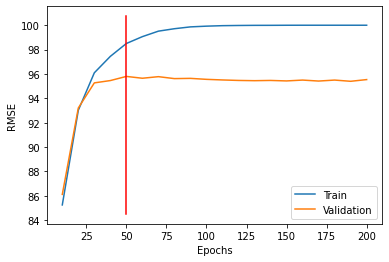

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [50]*4, method='sgd', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  92.09   Validation Accuracy:  92.14
epoch:  20   Train Accuracy:  92.98   Validation Accuracy:  92.78
epoch:  30   Train Accuracy:  93.098   Validation Accuracy:  92.78
epoch:  40   Train Accuracy:  93.154   Validation Accuracy:  92.7
epoch:  50   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  60   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  70   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  80   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  90   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  100   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  110   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  120   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  130   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  140   Train Accuracy:  93.254   Validation Accuracy:  92.82
epoch:  150   Train Accuracy:  93.254   Validation Accuracy:

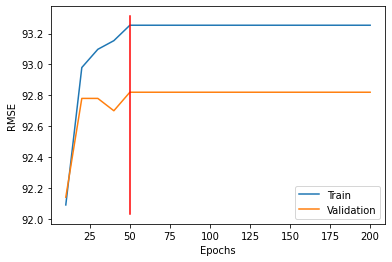

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [], method='sgd', learning_rate= 0.01) 

# SGD OBSERVSTIONS

* The best validation accuracy that I got for SGD was 97.27.
Increasing the number of epochs with one hidden layers of 20 units, did not have any effect on the validation accuracy. For the same, the best accuracy occurred at 50th epoch and interestingly after this point the training accuracy kept increasing but the validation accuracy kept decreasing which indicates over fitting of the data.

* Increasing or decreasing the number of epochs per train has no effect on the accuracy.

* Decreasing the learning rate has increased the accuracy very slightly but increasing the number of neurons upto 200 with just a single hidden layer gave the best validation accuracy for SGD. Increasing the number of layers to 4 with 50 neurons each gave accuracy of 95.8 which is better than the most of the configurations I tested but not the best. I feel that increasing the number of layers with each having about 200 would give the best accuracy for SGD.

* Even in SGD, the best validation accuracies are occurring at around 50th epoch even with increasing the number of layers. But, the best configuration (200 neurons) had its best validation accuracy at 90.

* Again, linear model performed well enough with validation 92.82 accuracy.


# ADAM

epoch:  10   Train Accuracy:  92.848   Validation Accuracy:  92.95
epoch:  20   Train Accuracy:  95.342   Validation Accuracy:  94.15
epoch:  30   Train Accuracy:  96.404   Validation Accuracy:  94.27
epoch:  40   Train Accuracy:  97.066   Validation Accuracy:  94.36
epoch:  50   Train Accuracy:  97.552   Validation Accuracy:  94.45
epoch:  60   Train Accuracy:  97.864   Validation Accuracy:  94.36
epoch:  70   Train Accuracy:  98.16   Validation Accuracy:  94.1
epoch:  80   Train Accuracy:  98.392   Validation Accuracy:  94.28
epoch:  90   Train Accuracy:  98.564   Validation Accuracy:  94.19
epoch:  100   Train Accuracy:  98.694   Validation Accuracy:  94.13
epoch:  110   Train Accuracy:  98.77   Validation Accuracy:  94.07
epoch:  120   Train Accuracy:  98.854   Validation Accuracy:  93.99
epoch:  130   Train Accuracy:  98.964   Validation Accuracy:  93.91
epoch:  140   Train Accuracy:  99.038   Validation Accuracy:  93.86
epoch:  150   Train Accuracy:  99.106   Validation Accuracy:

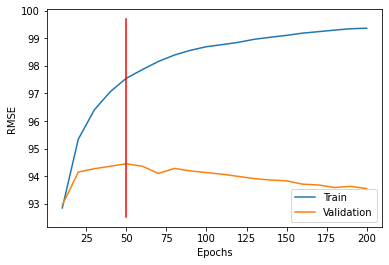

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='adam', learning_rate= 0.1) 

epoch:  20   Train Accuracy:  95.76   Validation Accuracy:  94.19
epoch:  40   Train Accuracy:  97.568   Validation Accuracy:  94.18
epoch:  60   Train Accuracy:  98.424   Validation Accuracy:  94.01
epoch:  80   Train Accuracy:  98.966   Validation Accuracy:  93.65
epoch:  100   Train Accuracy:  99.244   Validation Accuracy:  93.32
epoch:  120   Train Accuracy:  99.416   Validation Accuracy:  93.2
epoch:  140   Train Accuracy:  99.528   Validation Accuracy:  92.96
epoch:  160   Train Accuracy:  99.59   Validation Accuracy:  92.94
epoch:  180   Train Accuracy:  99.662   Validation Accuracy:  92.71
epoch:  200   Train Accuracy:  99.696   Validation Accuracy:  92.65
epoch:  220   Train Accuracy:  99.734   Validation Accuracy:  92.49
epoch:  240   Train Accuracy:  99.756   Validation Accuracy:  92.54
epoch:  260   Train Accuracy:  99.776   Validation Accuracy:  92.46
epoch:  280   Train Accuracy:  99.778   Validation Accuracy:  92.45
epoch:  300   Train Accuracy:  99.794   Validation Accu

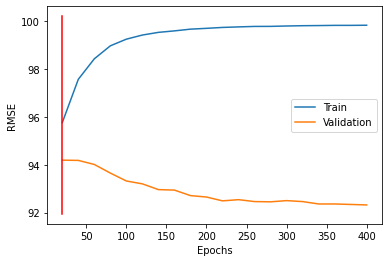

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      400, 20, [20], method='adam', learning_rate= 0.1) 

epoch:  5   Train Accuracy:  88.498   Validation Accuracy:  89.99
epoch:  10   Train Accuracy:  92.452   Validation Accuracy:  92.63
epoch:  15   Train Accuracy:  94.238   Validation Accuracy:  93.69
epoch:  20   Train Accuracy:  95.004   Validation Accuracy:  94.08
epoch:  25   Train Accuracy:  95.76   Validation Accuracy:  94.24
epoch:  30   Train Accuracy:  96.042   Validation Accuracy:  94.45
epoch:  35   Train Accuracy:  96.406   Validation Accuracy:  94.44
epoch:  40   Train Accuracy:  96.556   Validation Accuracy:  94.61
epoch:  45   Train Accuracy:  96.788   Validation Accuracy:  94.6
epoch:  50   Train Accuracy:  96.93   Validation Accuracy:  94.64
epoch:  55   Train Accuracy:  97.096   Validation Accuracy:  94.61
epoch:  60   Train Accuracy:  97.226   Validation Accuracy:  94.64
epoch:  65   Train Accuracy:  97.33   Validation Accuracy:  94.63
epoch:  70   Train Accuracy:  97.466   Validation Accuracy:  94.64
epoch:  75   Train Accuracy:  97.572   Validation Accuracy:  94.66


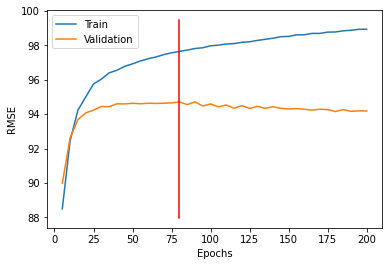

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 5, [20], method='adam', learning_rate= 0.1) 

epoch:  10   Train Accuracy:  92.758   Validation Accuracy:  92.88
epoch:  20   Train Accuracy:  95.482   Validation Accuracy:  94.24
epoch:  30   Train Accuracy:  96.638   Validation Accuracy:  94.19
epoch:  40   Train Accuracy:  97.24   Validation Accuracy:  94.23
epoch:  50   Train Accuracy:  97.694   Validation Accuracy:  94.2
epoch:  60   Train Accuracy:  98.008   Validation Accuracy:  94.2
epoch:  70   Train Accuracy:  98.214   Validation Accuracy:  94.11
epoch:  80   Train Accuracy:  98.406   Validation Accuracy:  93.97
epoch:  90   Train Accuracy:  98.648   Validation Accuracy:  94.04
epoch:  100   Train Accuracy:  98.742   Validation Accuracy:  93.84
epoch:  110   Train Accuracy:  98.9   Validation Accuracy:  94.01
epoch:  120   Train Accuracy:  99.03   Validation Accuracy:  93.78
epoch:  130   Train Accuracy:  99.134   Validation Accuracy:  93.91
epoch:  140   Train Accuracy:  99.192   Validation Accuracy:  93.71
epoch:  150   Train Accuracy:  99.268   Validation Accuracy:  9

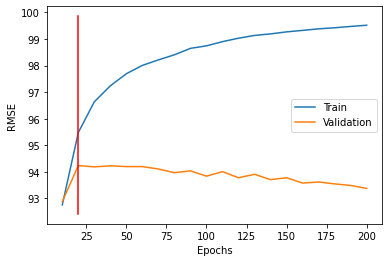

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='adam', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  91.684   Validation Accuracy:  91.93
epoch:  20   Train Accuracy:  94.804   Validation Accuracy:  93.98
epoch:  30   Train Accuracy:  96.008   Validation Accuracy:  94.1
epoch:  40   Train Accuracy:  96.658   Validation Accuracy:  94.33
epoch:  50   Train Accuracy:  97.186   Validation Accuracy:  94.15
epoch:  60   Train Accuracy:  97.538   Validation Accuracy:  94.13
epoch:  70   Train Accuracy:  97.832   Validation Accuracy:  93.99
epoch:  80   Train Accuracy:  98.004   Validation Accuracy:  94.0
epoch:  90   Train Accuracy:  98.224   Validation Accuracy:  94.07
epoch:  100   Train Accuracy:  98.394   Validation Accuracy:  93.92
epoch:  110   Train Accuracy:  98.584   Validation Accuracy:  93.89
epoch:  120   Train Accuracy:  98.678   Validation Accuracy:  93.81
epoch:  130   Train Accuracy:  98.776   Validation Accuracy:  93.84
epoch:  140   Train Accuracy:  98.874   Validation Accuracy:  93.66
epoch:  150   Train Accuracy:  99.024   Validation Accuracy

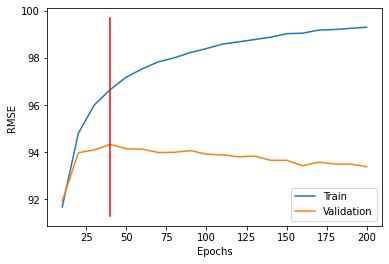

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='adam', learning_rate= 1) 

epoch:  10   Train Accuracy:  92.95   Validation Accuracy:  93.02
epoch:  20   Train Accuracy:  95.222   Validation Accuracy:  94.16
epoch:  30   Train Accuracy:  96.404   Validation Accuracy:  94.22
epoch:  40   Train Accuracy:  97.024   Validation Accuracy:  94.29
epoch:  50   Train Accuracy:  97.484   Validation Accuracy:  94.23
epoch:  60   Train Accuracy:  97.808   Validation Accuracy:  94.18
epoch:  70   Train Accuracy:  98.058   Validation Accuracy:  94.19
epoch:  80   Train Accuracy:  98.338   Validation Accuracy:  94.13
epoch:  90   Train Accuracy:  98.448   Validation Accuracy:  94.11
epoch:  100   Train Accuracy:  98.63   Validation Accuracy:  94.07
epoch:  110   Train Accuracy:  98.762   Validation Accuracy:  93.93
epoch:  120   Train Accuracy:  98.866   Validation Accuracy:  93.93
epoch:  130   Train Accuracy:  98.976   Validation Accuracy:  93.83
epoch:  140   Train Accuracy:  99.03   Validation Accuracy:  93.79
epoch:  150   Train Accuracy:  99.124   Validation Accuracy:

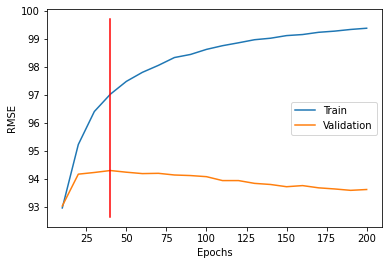

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [20], method='adam', learning_rate= 0.001) 

epoch:  10   Train Accuracy:  70.528   Validation Accuracy:  72.17
epoch:  20   Train Accuracy:  91.468   Validation Accuracy:  92.17
epoch:  30   Train Accuracy:  95.66   Validation Accuracy:  94.78
epoch:  40   Train Accuracy:  97.384   Validation Accuracy:  95.51
epoch:  50   Train Accuracy:  98.64   Validation Accuracy:  95.58
epoch:  60   Train Accuracy:  99.282   Validation Accuracy:  95.64
epoch:  70   Train Accuracy:  99.72   Validation Accuracy:  95.63
epoch:  80   Train Accuracy:  99.89   Validation Accuracy:  95.52
epoch:  90   Train Accuracy:  99.966   Validation Accuracy:  95.69
epoch:  100   Train Accuracy:  99.984   Validation Accuracy:  95.63
epoch:  110   Train Accuracy:  100.0   Validation Accuracy:  95.61
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  95.64
epoch:  130   Train Accuracy:  100.0   Validation Accuracy:  95.53
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  95.65
epoch:  150   Train Accuracy:  100.0   Validation Accuracy:  95.5

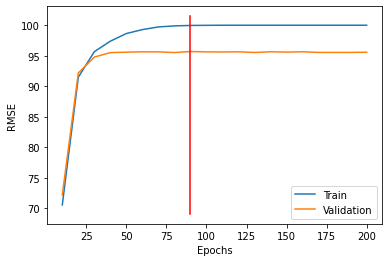

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [60,50,70], method='adam', learning_rate= 0.01) 

epoch:  10   Train Accuracy:  92.506   Validation Accuracy:  92.65
epoch:  20   Train Accuracy:  96.13   Validation Accuracy:  95.16
epoch:  30   Train Accuracy:  97.934   Validation Accuracy:  96.12
epoch:  40   Train Accuracy:  99.316   Validation Accuracy:  96.85
epoch:  50   Train Accuracy:  99.752   Validation Accuracy:  96.8
epoch:  60   Train Accuracy:  99.966   Validation Accuracy:  97.15
epoch:  70   Train Accuracy:  100.0   Validation Accuracy:  97.17
epoch:  80   Train Accuracy:  100.0   Validation Accuracy:  97.23
epoch:  90   Train Accuracy:  100.0   Validation Accuracy:  97.25
epoch:  100   Train Accuracy:  100.0   Validation Accuracy:  97.4
epoch:  110   Train Accuracy:  100.0   Validation Accuracy:  97.33
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  97.48
epoch:  130   Train Accuracy:  100.0   Validation Accuracy:  97.34
epoch:  140   Train Accuracy:  100.0   Validation Accuracy:  97.41
epoch:  150   Train Accuracy:  100.0   Validation Accuracy:  97.36
e

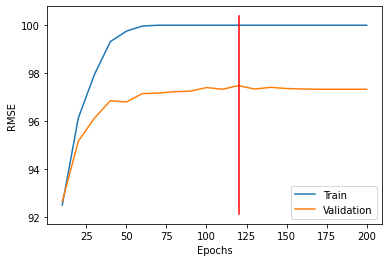

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      200, 10, [300], method='adam', learning_rate= 0.01) 

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      300, 10, [50]*5, method='adam', learning_rate= 0.01) 

KeyboardInterrupt: ignored

epoch:  10   Train Accuracy:  92.042   Validation Accuracy:  92.2
epoch:  20   Train Accuracy:  93.136   Validation Accuracy:  92.74
epoch:  30   Train Accuracy:  93.38   Validation Accuracy:  92.82
epoch:  40   Train Accuracy:  93.678   Validation Accuracy:  92.77
epoch:  50   Train Accuracy:  93.664   Validation Accuracy:  92.93
epoch:  60   Train Accuracy:  93.728   Validation Accuracy:  92.85
epoch:  70   Train Accuracy:  93.728   Validation Accuracy:  92.89
epoch:  80   Train Accuracy:  93.774   Validation Accuracy:  92.86
epoch:  90   Train Accuracy:  93.79   Validation Accuracy:  92.89
epoch:  100   Train Accuracy:  93.822   Validation Accuracy:  92.87
Best test error is at epoch 50.0 with  Train Accuracy of 93.66 and Validation Accuracy of 92.93


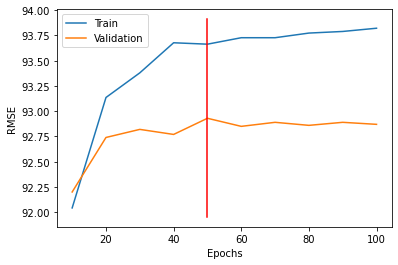

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      100, 10, [], method='adam', learning_rate= 0.01) 

# ADAM OBSERVATIONS

* The best validation accuracy that I got for SGD was 97.48. 
Increasing the number of epochs increased the train accuracy but not validation accuracy which indicates over fitting. But in SCG and SGD increasing the number of epochs did not lead to over fitting all the time.
* Increasing or decreasing the learning rate did not effect the accuracy much. Increasing the number of neurons to 300 with just one hidden layer gave the best accuracy of 97.48 for adam. Increasing the number of layers also increased. I believe with around 10 layers 200 neurons each would give even better accuracy. 
* For most of the configurations, the best validation accuracy occurred at 50th epoch and below but increasing the number of neurons changed this to 125th epoch. This shows that increasing the number of neurons is actually helping to find new features and data rather than over fitting.
Again, changing the number of epochs per train has no effect on the accuracies.
* The linear model with no hidden layers performed just like SGD and SCG with a validation accuracy of 92.93. 



# BEST MODEL

epoch:  10   Train Accuracy:  92.56   Validation Accuracy:  92.84
epoch:  20   Train Accuracy:  96.23   Validation Accuracy:  95.56
epoch:  30   Train Accuracy:  97.902   Validation Accuracy:  96.13
epoch:  40   Train Accuracy:  99.256   Validation Accuracy:  96.98
epoch:  50   Train Accuracy:  99.73   Validation Accuracy:  96.93
epoch:  60   Train Accuracy:  99.968   Validation Accuracy:  97.17
epoch:  70   Train Accuracy:  99.998   Validation Accuracy:  97.09
epoch:  80   Train Accuracy:  100.0   Validation Accuracy:  97.22
epoch:  90   Train Accuracy:  100.0   Validation Accuracy:  97.17
epoch:  100   Train Accuracy:  100.0   Validation Accuracy:  97.3
epoch:  110   Train Accuracy:  100.0   Validation Accuracy:  97.21
epoch:  120   Train Accuracy:  100.0   Validation Accuracy:  97.39
Best test error is at epoch 120.0 with  Train Accuracy of 100.00 and Validation Accuracy of 97.39


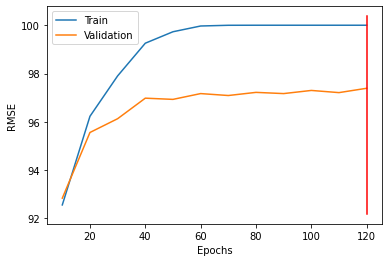

In [ ]:
nnet, epoch, train_accuracy, val_accuracy = train_for_best_validation(Xtrain, Ttrain,  Xval, Tval, 
                                                                      120, 10, [300], method='adam', learning_rate= 0.01) 

# BEST MODEL CONFUSION MATRICES

TRAIN DATA

In [ ]:
confusion_matrix(nnet.use(Xtrain)[0], Ttrain)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.0,0.1,0.3,0.2,0.2,0.5,0.8,0.3,0.4,0.1
1,0.0,97.0,0.6,0.4,0.2,0.3,0.0,0.3,1.0,0.2
2,0.6,0.8,92.0,1.0,1.1,0.4,0.7,1.2,1.7,0.4
3,0.4,0.4,2.2,89.4,0.2,3.5,0.3,1.1,1.7,0.9
4,0.2,0.5,0.6,0.0,92.2,0.1,0.8,0.2,0.5,5.0
5,1.1,0.7,0.5,2.3,1.2,89.8,1.3,0.4,1.8,0.9
6,0.6,0.3,0.5,0.0,0.8,1.5,95.8,0.1,0.3,0.0
7,0.2,0.8,1.1,0.4,0.8,0.2,0.1,92.2,0.1,4.1
8,1.0,2.8,1.0,2.1,0.6,2.9,1.1,0.3,86.8,1.5
9,0.4,0.4,0.2,1.0,2.1,0.5,0.0,2.1,0.7,92.6


VALIDATION DATA

In [ ]:
confusion_matrix(nnet.use(Xval)[0], Tval)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.5,0.0,0.4,0.2,0.4,0.3,0.7,0.2,0.2,0.1
1,0.0,98.3,0.4,0.4,0.1,0.3,0.0,0.1,0.4,0.1
2,0.5,1.0,92.4,1.1,1.5,0.5,0.3,1.0,1.3,0.3
3,0.8,0.2,1.3,88.3,0.2,4.7,0.3,0.9,2.2,1.2
4,0.1,1.2,0.1,0.1,93.4,0.0,0.6,0.4,0.3,3.8
5,1.4,0.3,1.2,2.7,0.8,88.5,2.3,0.5,1.5,0.7
6,0.3,0.3,1.1,0.0,0.6,0.9,96.6,0.0,0.1,0.0
7,0.5,1.1,0.8,0.5,0.5,0.0,0.0,93.8,0.0,2.9
8,0.7,3.6,0.6,2.5,0.2,2.5,0.7,0.6,86.5,2.2
9,0.4,0.5,0.3,0.9,2.0,0.6,0.1,2.2,0.3,92.6


TEST DATA

In [ ]:
confusion_matrix(nnet.use(Xtest)[0], Ttest)

Percent Correct


,0,1,2,3,4,5,6,7,8,9
0,97.7,0.0,0.0,0.1,0.0,0.5,1.1,0.4,0.2,0.0
1,0.0,98.1,0.3,0.1,0.1,0.1,0.4,0.1,0.9,0.0
2,0.8,0.6,90.7,1.6,0.9,0.5,1.2,1.1,2.3,0.4
3,0.3,0.1,1.4,90.8,0.3,3.3,0.1,1.3,1.4,1.1
4,0.0,0.5,0.5,0.0,92.8,0.1,0.8,0.4,0.4,4.5
5,1.1,0.3,0.2,3.0,1.5,87.8,1.9,1.0,2.2,0.9
6,0.9,0.3,0.5,0.1,0.9,1.8,94.9,0.3,0.2,0.0
7,0.2,1.1,2.0,0.9,0.6,0.1,0.0,91.2,0.0,3.9
8,0.9,1.0,0.7,2.1,1.3,3.3,0.9,1.2,87.4,1.1
9,1.2,0.6,0.1,1.0,2.2,0.6,0.0,1.6,0.5,92.3


GENERAL OBSERVATIONS

*  The best model accuracy could still be increased with more number of epoches because the validation curve is still ever so slightly rising.

* SGD and adam seem to perform very with increase in number of nuerons and layers drastically. From my observation with 10-15 layers with about 300 neurons each with adam could give the best accuracy.

* On a side note, I feel that all the configurations have taken significantly longer time than when I used keras library. I feel this is because the code we wrote is not optimized to run on the GPUS.

* inccreasing the number of epoches is not always leading to over fitting.

* Looking at the confusion matrix for test data, I observed that 

  0 and 1 are easily being detected out of all the others with 97 and 98 percent accuracy respectively.

  5 and 8 are have the least accuracies with 97 percent.

  It is interesting to see that (9,4) and (4,9) have higher error value as they have a somwhat similar shape. Whats more intersting is 9 being deteced as 4 has less error than 4 being deteced as 9. similary 7 and 9.

  dissimialr shapes like 3,4 or 7,6 etc have zero error which is great. 


# New Section

Call `train_for_best_validation` a number of times to compare accuracies using the three different optimization methods, and a few different values of `n_epochs`, `n_epochs_per_train`, and `n_hiddens_list`, and `learning_rate` when using 'sgd' and 'adam'.  You do not have to find the very best values of these parameters.  For example, for `n_hiddens_list` at least use `[]` (a linear model) and a larger network, like `[100, 100]`.

Show the confusion matrix for the network that gave you the best validation accuracy.

Write at least 10 sentences about what you observe in the accuracy plots, the train, validation and test accuracies, and the confusion matrix.

# Grading

Download [A4grader.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/A4grader.tar), extract `A4grader.py` before running the following cell.

In [ ]:
# %run -i A4grader.py

# Extra Credit

Repeat the above experiments with a different data set.  Randonly partition your data into training, validaton and test parts if not already provided.  Write in markdown cells descriptions of the data and your results.